(example-tn-training-circuits)=

# Tensor Network Training of Quantum Circuits

Here we'll run through constructing a tensor network of an ansatz quantum circuit, then training certain 'parametrizable' tensors representing quantum gates in that tensor network to replicate the behaviour of a target unitary.

In [1]:
%config InlineBackend.figure_formats = ['svg']
import quimb as qu
import quimb.tensor as qtn

## The Ansatz Circuit

First we set up the ansatz circuit and extract the tensor network. Key here is that when we supply `parametrize=True` to the `'U3'` gate call, it injects a {class}`~quimb.tensor.tensor_core.PTensor` into the network, which lazily represents its data array with a function and set of parameters. Later, when the optimizer
sees this it then knows to optimize the parameters rather than the array itself.

In [ ]:
def single_qubit_layer(circ, gate_round=None):
    """Apply a parametrizable layer of single qubit ``U3`` gates."""
    for i in range(circ.N):
        # initialize with random parameters
        params = qu.randn(3, dist="uniform")
        circ.apply_gate(
            "U3", *params, i, gate_round=gate_round, parametrize=True
        )


def two_qubit_layer(circ, gate2="CZ", reverse=False, gate_round=None):
    """Apply a layer of constant entangling gates."""
    regs = range(0, circ.N - 1)
    if reverse:
        regs = reversed(regs)

    for i in regs:
        circ.apply_gate(gate2, i, i + 1, gate_round=gate_round)


def ansatz_circuit(n, depth, gate2="CZ", **kwargs):
    """Construct a circuit of single qubit and entangling layers."""
    circ = qtn.Circuit(n, **kwargs)

    for r in range(depth):
        # single qubit gate layer
        single_qubit_layer(circ, gate_round=r)

        # alternate between forward and backward CZ layers
        two_qubit_layer(circ, gate2=gate2, gate_round=r, reverse=r % 2 == 0)

    # add a final single qubit layer
    single_qubit_layer(circ, gate_round=r + 1)

    return circ

The form of the `'U3'` gate (which generalizes all possible single qubit gates) can be seen here - {func}`~quimb.gen.operators.U_gate`. Now we are ready to instantiate a circuit:

In [3]:
n = 6
depth = 9
gate2 = "CZ"

circ = ansatz_circuit(n, depth, gate2=gate2)
circ

<Circuit(n=6, num_gates=105, gate_opts={'contract': 'auto-split-gate', 'propagate_tags': 'register'})>

We can extract just the unitary part of the circuit as a tensor network like so:

In [4]:
V = circ.uni

/media/johnnie/Storage2TB/Sync/dev/python/quimb/quimb/tensor/circuit.py:1194: FutureWarning: In future the tensor network returned by ``circ.uni`` will not be transposed as it is currently, to match the expectation from ``U = circ.uni.to_dense()`` behaving like ``U @ psi``. You can retain this behaviour with ``circ.get_uni(transposed=True)``.
  warnings.warn(


You can see it already has various ``tags`` simultaneously identifying different structures:

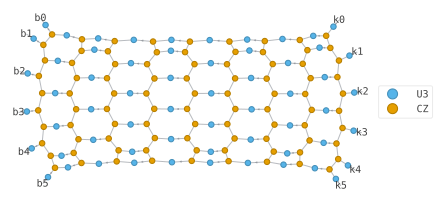

In [5]:
# types of gate
V.draw(color=["U3", gate2], show_inds=True)

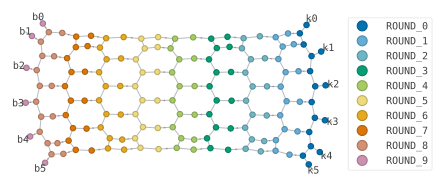

In [6]:
# layers of gates
V.draw(color=[f"ROUND_{i}" for i in range(depth + 1)], show_inds=True)

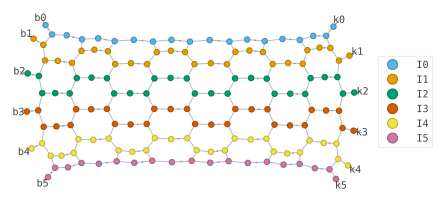

In [7]:
# what register each tensor is 'above'
V.draw(color=[f"I{i}" for i in range(n)], show_inds=True)

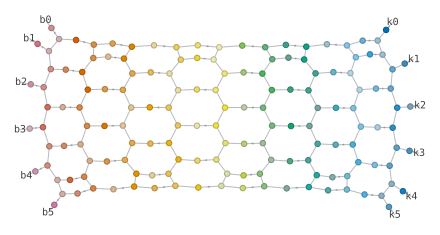

In [8]:
# a unique tag for per gate applied
V.draw(color=[f"GATE_{i}" for i in range(circ.num_gates)], legend=False)

## The Target Unitary

Next we need a target unitary to try and digitially replicate. Here we'll take an Ising Hamiltonian and a short time evolution. Once we have the dense (matrix) form of the target unitary \$U\$ we need to convert it to a tensor which we can put in a tensor network:

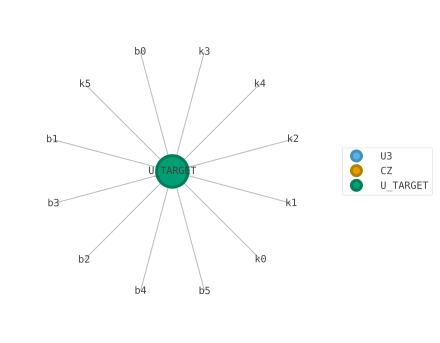

In [9]:
# the hamiltonian
H = qu.ham_ising(n, jz=1.0, bx=0.7, cyclic=False)

# the propagator for the hamiltonian
t = 2
U_dense = qu.expm(-1j * t * H)

# 'tensorized' version of the unitary propagator
U = qtn.Tensor(
    data=U_dense.reshape([2] * (2 * n)),
    inds=[f"k{i}" for i in range(n)] + [f"b{i}" for i in range(n)],
    tags={"U_TARGET"},
)
U.draw(color=["U3", gate2, "U_TARGET"])

The core object describing how similar two unitaries are is: $\mathrm{Tr}(V^{\dagger}U)$, which we can naturally visualize at a tensor network:

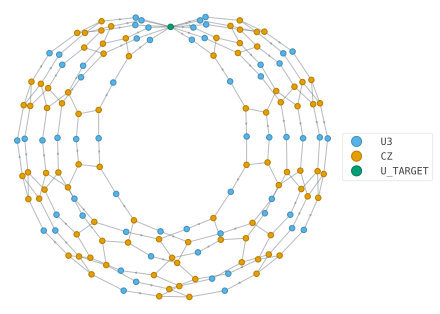

In [10]:
(V.H & U).draw(color=["U3", gate2, "U_TARGET"])

For our loss function we'll normalize this and negate it (since the optimizer *minimizes*).

In [11]:
def loss(V, U):
    return 1 - abs((V.H & U).contract(all, optimize="auto-hq")) / 2**n


# check our current unitary 'infidelity':
loss(V, U)

0.9881326237593226

So as expected currently the two unitaries are not similar *at all*.

## The Tensor Network Optimization

Now we are ready to construct the {class}`~quimb.tensor.optimize.TNOptimizer` object, with options detailed below:

In [12]:
# use the autograd/jax based optimizer

tnopt = qtn.TNOptimizer(
    V,  # the tensor network we want to optimize
    loss,  # the function we want to minimize
    loss_constants={"U": U},  # supply U to the loss function as a constant TN
    tags=["U3"],  # only optimize U3 tensors
    autodiff_backend="jax",  # use 'autograd' for non-compiled optimization
    optimizer="L-BFGS-B",  # the optimization algorithm
)

:::{note}
If `tags` is not specified the default is to optimize **all** tensors.
In that case, instead of specifying tensor tags to opt-in you can use
`constant_tags` to opt-out tensors tags you *don't* want to optimize,
which may be more convenient.
:::

We could call `optimize` for pure gradient based optimization, but since
unitary circuits can be tricky we'll use `optimize_basinhopping` which
combines gradient descent with 'hopping' to escape local minima:

In [13]:
# allow 10 hops with 500 steps in each 'basin'
V_opt = tnopt.optimize_basinhopping(n=500, nhop=10)

+0.005301594734 [best: +0.005261898041] :  45%|████▌     | 2258/5000 [00:40<00:49, 55.26it/s]


The optimized tensor network still contains ``PTensor`` instances but now with optimized parameters.
For example, here's the tensor of the ``U3`` gate acting on qubit-2 in round-4:

In [14]:
V_opt["U3", "I2", "ROUND_4"]

PTensor(shape=(2, 2), inds=('_8d3684AAABr', '_8d3684AAABh'), tags=oset(['GATE_46', 'ROUND_4', 'U3', 'I2']))

We can see the parameters have been updated by the training:

In [15]:
# the initial values
V["U3", "ROUND_4", "I2"].params

array([0.25927184, 0.10598236, 0.42593174])

In [16]:
# the optimized values
V_opt["U3", "ROUND_4", "I2"].params

array([ 0.52709323,  0.6036498 , -0.23340225], dtype=float32)

We can see what gate these parameters would generate:

In [17]:
qu.U_gate(*V_opt["U3", "ROUND_4", "I2"].params)

[[ 0.965472-0.j       -0.253443+0.060252j]
 [ 0.214467+0.147877j  0.90005 +0.349352j]]

A final sanity check we can perform is to try evolving a random state with the target unitary and trained circuit and check the fidelity between the resulting states.

First we turn the tensor network version of $V$ into a dense matrix:

In [18]:
V_opt_dense = V_opt.to_dense(
    [f"k{i}" for i in range(n)], [f"b{i}" for i in range(n)]
)

Next we create a random initial state, and evolve it with the

In [19]:
psi0 = qu.rand_ket(2**n)

# this is the exact state we want
psif_exact = U_dense @ psi0

# this is the state our circuit will produce if fed `psi0`
psif_apprx = V_opt_dense @ psi0

The (in)fidelity should broadly match our training loss:

In [20]:
f"Fidelity: {100 * qu.fidelity(psif_apprx, psif_exact):.2f} %"

'Fidelity: 99.57 %'

## Extracting the New Circuit

We can extract the trained circuit parameters by updating the original
{class}`~quimb.tensor.circuit.Circuit` object from the trained TN:

In [21]:
circ.update_params_from(V_opt)

# the basic gate specification
circ.gates

[<Gate(label=U3, params=(0.16929962, -0.6534094, -0.25308686), qubits=(0,), round=0, parametrize=True))>,
 <Gate(label=U3, params=(-0.8037065, -0.25300127, 1.5709982), qubits=(1,), round=0, parametrize=True))>,
 <Gate(label=U3, params=(-1.0775858, 0.29377267, 1.573218), qubits=(2,), round=0, parametrize=True))>,
 <Gate(label=U3, params=(-0.70041966, -0.54078287, 1.5730082), qubits=(3,), round=0, parametrize=True))>,
 <Gate(label=U3, params=(2.233548, -0.6997934, 1.5887524), qubits=(4,), round=0, parametrize=True))>,
 <Gate(label=U3, params=(2.6693592, -0.3773012, 1.6181816), qubits=(5,), round=0, parametrize=True))>,
 <Gate(label=CZ, params=(), qubits=(4, 5), round=0)>,
 <Gate(label=CZ, params=(), qubits=(3, 4), round=0)>,
 <Gate(label=CZ, params=(), qubits=(2, 3), round=0)>,
 <Gate(label=CZ, params=(), qubits=(1, 2), round=0)>,
 <Gate(label=CZ, params=(), qubits=(0, 1), round=0)>,
 <Gate(label=U3, params=(0.9794985, -0.1482388, 0.3628862), qubits=(0,), round=1, parametrize=True))>,
 <